In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

In [3]:
PATH_TO_DATA = '../../datasets/'
SEED = 17

In [4]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict,
                           vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train,
                       index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test,
                      index_col='session_id', parse_dates=times)

    # Sort the data by time
    train_df = train_df.sort_values(by='time1')

    # read site -> id mapping provided by competition organizers
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create an inverse id _> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # we treat site with id 0 as "unknown"
    id2site[0] = 'unknown'

    # Transform data into format which can be fed into TfidfVectorizer
    # This time we prefer to represent sessions with site names, not site ids.
    # It's less efficient but thus it'll be more convenient to interpret model weights.
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row:
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row:
                                                     ' '.join([id2site[i] for i in row]), axis=1).tolist()
    # we'll tell TfidfVectorizer that we'd like to split data by whitespaces only
    # so that it doesn't split by dots (we wouldn't like to have 'mail.google.com'
    # to be split into 'mail', 'google' and 'com')
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values

    # we'll need site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]

    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [5]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={'ngram_range': (1, 5),
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
)

Wall time: 33.1 s


In [6]:
print(X_train_sites.shape, X_test_sites.shape)

(253561, 50000) (82797, 50000)


In [7]:
vectorizer.get_feature_names()[:10]

['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com apis.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.drive.google.com 0.docs.google.com']

In [8]:
time_split = TimeSeriesSplit(n_splits=10)

In [9]:
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [10]:
%%time

cv_scores1 = cross_val_score(logit, X_train_sites, y_train, cv=time_split,
                            scoring='roc_auc', n_jobs=4) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 5.89 s


In [11]:
cv_scores1, cv_scores1.mean()

(array([0.83124023, 0.65993466, 0.85673565, 0.92824237, 0.84779639,
        0.88954524, 0.88829128, 0.8771044 , 0.92023038, 0.92624225]),
 0.8625362859611094)

In [12]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, random_state=17, solver='liblinear')

In [13]:
eli5.show_weights(estimator=logit,
                  feature_names=vectorizer.get_feature_names(), top=30)

Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [14]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [15]:
logit_test_pred = logit.predict_proba(X_test_sites)[:, 1]
write_to_submission_file(logit_test_pred, 'subm1.csv')

In [16]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=vectorizer.get_feature_names(),
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):


    cv_scores = cross_val_score(model, X_train, y_train, cv=cv,
                            scoring=scoring, n_jobs=4)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)

    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names
    else:
        all_feature_names = site_feature_names

    display_html(eli5.show_weights(estimator=model,
                  feature_names=all_feature_names, top=top_n_features_to_show))

    if new_feature_names:
        print('New feature weights:')

        print(pd.DataFrame({'feature': new_feature_names,
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))

    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name)

    return cv_scores

In [17]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train_sites, y_train=y_train,
                  X_test=X_test_sites, site_feature_names=vectorizer.get_feature_names(),
                  cv=time_split, submission_file_name='subm1.csv')

CV scores [0.83124023 0.65993466 0.85673565 0.92824237 0.84779639 0.88954524
 0.88829128 0.8771044  0.92023038 0.92624225]
CV mean: 0.8625362859611094, CV std: 0.07455679334182559


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


In [18]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


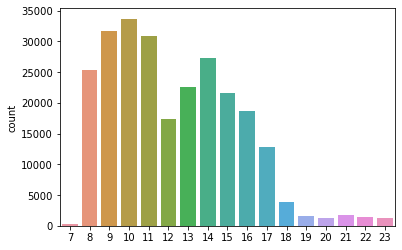

In [19]:
sns.countplot(session_start_hour);

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


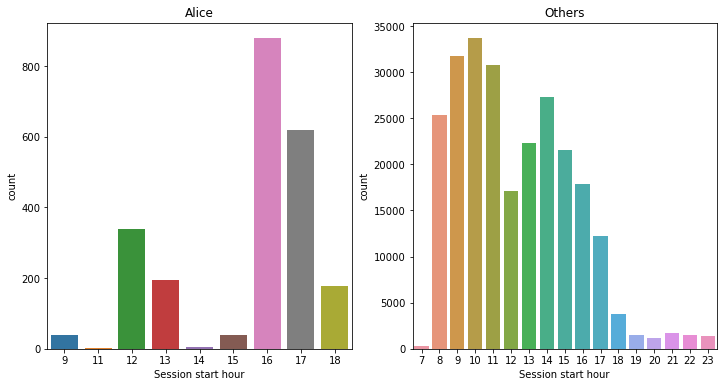

In [20]:
plt.subplots(1, 2, figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start hour')

plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');

In [21]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [22]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

In [23]:
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)

    objects_to_hstack = [X_sparse, morning, day, evening, night]
    feature_names = ['morning', 'day', 'evening', 'night']

    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')

    X = hstack(objects_to_hstack)
    return X, feature_names

In [24]:
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)

In [25]:
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

In [26]:
X_train_with_times1.shape, X_test_with_times1.shape

((253561, 50005), (82797, 50005))

In [27]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train,
                               X_test=X_test_with_times1,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm2.csv')

CV scores [0.81904687 0.78705941 0.94510729 0.96676653 0.88993687 0.96695898
 0.91829701 0.93962258 0.96595914 0.96884529]
CV mean: 0.9167599976315433, CV std: 0.06210654781760998
New feature weights:
   feature      coef
0  morning -2.904834
1      day -0.613843
2  evening -5.069778
3    night  0.000000
4     hour  7.045653


Weight?,Feature
+7.046,hour
+5.148,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.986,www.express.co.uk
+4.833,youwatch.org
+4.804,www.info-jeunes.net
+4.679,vk.com
+4.567,www.melty.fr
+4.330,fr.glee.wikia.com
+4.100,www.audienceinsights.net
+3.962,www.banque-chalus.fr


In [28]:
cv_scores2 > cv_scores1

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [29]:
%%time
X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, add_hour=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, add_hour=False)


cv_scores3 = train_and_predict(model=logit, X_train=X_train_with_times2, y_train=y_train,
                               X_test=X_test_with_times2,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm3.csv')

CV scores [0.88170019 0.81426901 0.91861447 0.96171465 0.91533019 0.95227476
 0.92804771 0.94016178 0.94665449 0.95277436]
CV mean: 0.9211541597021163, CV std: 0.04206421153022573
New feature weights:
   feature      coef
0  morning -3.211819
1      day  0.526636
2  evening -2.721465
3    night  0.000000
Wall time: 9.36 s


Weight?,Feature
+5.218,youwatch.org
+5.093,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.914,vk.com
+4.640,fr.glee.wikia.com
+4.542,www.info-jeunes.net
+4.382,www.melty.fr
+4.183,www.audienceinsights.net
+4.104,www.banque-chalus.fr
+3.823,r4---sn-gxo5uxg-jqbe.googlevideo.com


In [30]:
def add_session_duration_incorrect(times, X_sparse):
    new_feat = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
    return hstack([X_sparse, new_feat.values.reshape(-1, 1)])

In [31]:
X_train_with_time_incorrect = add_session_duration_incorrect(train_times, X_train_with_times2)
X_test_with_time_incorrect = add_session_duration_incorrect(test_times, X_test_with_times2)

In [32]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_incorrect, y_train=y_train,
                               X_test=X_test_with_time_incorrect,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm4.csv')

CV scores [0.57324417 0.6057354  0.59064502 0.55137641 0.63484782 0.66004053
 0.74572105 0.67174803 0.61461151 0.61200149]
CV mean: 0.6259971432088414, CV std: 0.05291615658123371
New feature weights:
         feature      coef
0        morning -0.689711
1            day -0.602607
2        evening -0.045053
3          night  0.000000
4  sess_duration -0.000044


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 
 … 1784 more positive … 
 
 
 

 
 
 
 … 48191 more negative … 
 
 
 
 
 
 
 -0.009
 
 
 khms1.google.fr
 
 
 
 
 
 
 -0.009
 
 
 ts2.mm.bing.net
 
 
 
 
 
 
 -0.010
 
 
 s.ytimg.com
 
 
 
 
 
 
 -0.010
 
 
 www.youtube.com
 
 
 
 
 
 
 -0.010
 
 
 mail.google.com
 
 
 
 
 
 
 -0.011
 
 
 clients1.google.com
 
 
 
 
 
 
 -0.012
 
 
 mts1.google.com
 
 
 
 
 
 
 -0.012
 
 
 ajax.googleapis.com
 
 
 
 
 
 
 -0.012
 
 
 twitter.com
 
 
 
 
 
 
 -0.012
 
 
 mts0.google.com
 
 
 
 
 
 
 -0.014
 
 
 accounts.google.com
 
 
 
 
 
 
 -0.015
 
 
 ts1.mm.bing.net
 
 
 
 
 
 
 -0.015
 
 
 connect.facebook.net
 
 
 
 
 
 
 -0.019
 
 
 www.google.fr
 
 
 
 
 
 
 -0.021
 
 
 s-static.ak.facebook.com
 
 
 
 
 
 
 -0.022
 
 
 static.ak.facebook.com
 
 
 
 
 
 
 -0.023
 
 
 www.bing.com
 
 
 
 
 
 
 -0.024
 
 
 apis.google.com
 
 
 
 
 
 
 -0.025
 
 
 www.google.com
 
 
 
 
 
 
 -0.026
 
 
 platform.twitter.com
 
 
 
 
 
 
 -0.038
 
 
 www.facebook.com
 
 
 
 
 
 
 -0.044
 
 
 unknown unknown unknown unknown unknown
 
 
 
 
 
 
 -0.045
 
 
 evening
 
 
 
 
 
 
 -0.054
 
 
 unknown unknown unknown unknown
 
 
 
 
 
 
 -0.065
 
 
 unknown unknown unknown
 
 
 
 
 
 
 -0.075
 
 
 unknown unknown
 
 
 
 
 
 
 -0.084
 
 
 unknown
 
 
 
 
 
 
 -0.603
 
 
 day
 
 
 
 
 
 
 -0.690
 
 
 morning
 
 
 
 
 
 
 -1.337
 
 
 <BIAS>

In [33]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

In [34]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

In [35]:
cv_scores5 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train,
                               X_test=X_test_with_time_correct,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm5.csv')

CV scores [0.86809822 0.81821851 0.91950143 0.96171682 0.91593618 0.95368912
 0.93027726 0.94128874 0.94847477 0.95287352]
CV mean: 0.9210074562651493, CV std: 0.04287824906593912
New feature weights:
         feature      coef
0        morning -3.230468
1            day  0.509579
2        evening -2.722820
3          night  0.000000
4  sess_duration -0.241711


Weight?,Feature
+5.212,youwatch.org
+5.058,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.974,vk.com
+4.969,www.express.co.uk
+4.617,fr.glee.wikia.com
+4.532,www.info-jeunes.net
+4.363,www.melty.fr
+4.148,www.banque-chalus.fr
+4.146,www.audienceinsights.net
+3.792,r4---sn-gxo5uxg-jqbe.googlevideo.com


In [36]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1)
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5

    objects_to_hstack = [X_sparse, day_of_week, month, year_month]
    feature_names = ['day_of_week', 'month', 'year_month']

    X = hstack(objects_to_hstack)
    return X, feature_names

In [37]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

In [38]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train,
                               X_test=X_test_final,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm6.csv')

CV scores [0.76714843 0.81597079 0.90540725 0.96307368 0.91634775 0.95852658
 0.92722248 0.95188156 0.95890711 0.96919612]
CV mean: 0.9133681759819172, CV std: 0.06504953159343752
New feature weights:
         feature      coef
0        morning -1.660448
1            day  2.059677
2        evening -1.737744
3          night  0.000000
4  sess_duration -0.262807
5    day_of_week -0.367643
6          month  0.108567
7     year_month -2.754056


Weight?,Feature
+5.163,youwatch.org
+5.039,vk.com
+5.011,www.express.co.uk
+4.985,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.689,www.info-jeunes.net
+4.441,www.melty.fr
+4.387,fr.glee.wikia.com
+4.335,www.audienceinsights.net
+4.021,www.banque-chalus.fr
+3.963,api.bing.com


In [39]:
c_values = np.logspace(-2, 2, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=4, cv=time_split, verbose=1)

In [40]:
%%time
logit_grid_searcher.fit(X_train_final, y_train);

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Wall time: 3min 20s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=1, random_state=17,
                                          solver='liblinear'),
             n_jobs=4,
             param_grid={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])},
             scoring='roc_auc', verbose=1)

In [41]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9164733150672554, {'C': 3.359818286283781})

In [42]:
final_model = logit_grid_searcher.best_estimator_

In [43]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train,
                               X_test=X_test_final,
                               site_feature_names=vectorizer.get_feature_names(),
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm7.csv')

CV scores [0.78590509 0.8006631  0.91498106 0.96944336 0.91975221 0.95615006
 0.9413044  0.94704704 0.96257521 0.96691162]
CV mean: 0.9164733150672554, CV std: 0.06408888998138046
New feature weights:
         feature      coef
0        morning -1.483960
1            day  2.336346
2        evening -2.327626
3          night  0.000000
4  sess_duration -0.211600
5    day_of_week -0.372500
6          month  0.124815
7     year_month -3.164381


Weight?,Feature
+11.114,www.express.co.uk
+9.802,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.028,tru.am
+6.362,browser-update.org
+6.012,fr.glee.wikia.com
+5.793,api.bing.com
+5.777,www.banque-chalus.fr
+5.651,youwatch.org
+5.504,vk.com
+5.402,glee.hypnoweb.net


In [44]:
logit_solver_searcher = GridSearchCV(estimator=final_model, param_grid={'solver': ['lbfgs', 'liblinear']}, scoring='roc_auc', n_jobs=4, cv=time_split, verbose=1)

In [45]:
%%time
logit_solver_searcher.fit(X_train_final, y_train);


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Wall time: 25.2 s


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   20.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=3.359818286283781, random_state=17,
                                          solver='liblinear'),
             n_jobs=4, param_grid={'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=1)

In [46]:
logit_solver_searcher.best_score_, logit_solver_searcher.best_params_

(0.9164733150672554, {'solver': 'liblinear'})

In [47]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [48]:
selector = SequentialFeatureSelector(final_model, scoring='roc_auc',
                                     verbose=2, k_features=3, forward=False, n_jobs=-1)

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [50]:
session_start_year = train_times['time1'].apply(lambda ts: ts.year).values

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


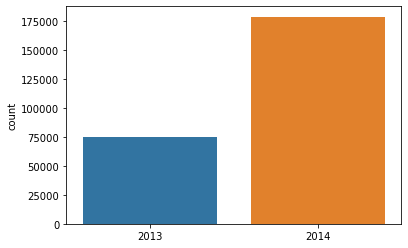

In [52]:
sns.countplot(session_start_year);

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


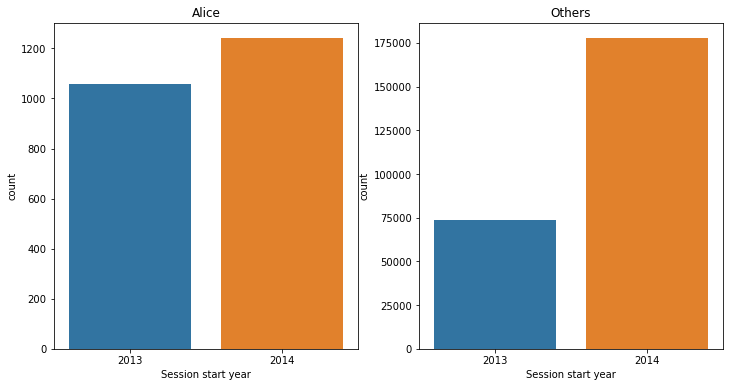

In [53]:
plt.subplots(1, 2, figsize = (12, 6))

plt.subplot(1, 2, 1)
sns.countplot(session_start_year[y_train == 1])
plt.title("Alice")
plt.xlabel('Session start year')

plt.subplot(1, 2, 2)
sns.countplot(session_start_year[y_train == 0])
plt.title('Others')
plt.xlabel('Session start year');